In [342]:
!pip install ltn torch numpy pandas matplotlib scikit-learn

In [343]:
import platform
import torch
import torch.nn as nn
import numpy as np
import random
import ltn
import os
import csv

from itertools import combinations
from functools import reduce
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

torch.set_num_threads(1)

print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("LTN:", getattr(ltn, "__version__", "unknown"))


Python: 3.13.11
Torch: 2.9.1+cu128
LTN: unknown


In [344]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def reset_predicates(predicates):
    for p in predicates:
        model = getattr(p, "model", None)
        if model is not None:
            for m in model.modules():
                if hasattr(m, "reset_parameters"):
                    m.reset_parameters()

In [345]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Ambiente pronto. Usando dispositivo: {device}")

Ambiente pronto. Usando dispositivo: cuda


In [346]:
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or  = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Impl = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())

Forall = ltn.Quantifier(
    ltn.fuzzy_ops.AggregPMeanError(p=2),
    quantifier="f"
)

Exists = ltn.Quantifier(
    ltn.fuzzy_ops.AggregPMean(p=8),
    quantifier="e"
)

satAgg = ltn.fuzzy_ops.SatAgg()

In [347]:
def generate_clevr_dataset():
    data = [
        # x, y,     R G B,  C Q Cy Co T, size
        [0.02,0.26, 0,0,1,  1,0,0,0,0,   0.0],  # 1 Circulo Azul
        [0.10,0.16, 0,0,1,  0,1,0,0,0,   0.5],  # 2 Quadrado Azul
        [0.18,0.12, 1,0,0,  0,0,0,0,1,   0.0],  # 3 Triangulo Vermelho
        [0.21,0.48, 0,0,1,  0,0,0,1,0,   0.5],  # 4 Cone Azul
        [0.20,0.36, 1,1,0,  1,0,0,0,0,   0.5],  # 5 Circulo Amarelo
        [0.25,0.59, 1,0,0,  0,0,0,0,1,   0.0],  # 6 Triangulo Vermelho
        [0.38,0.56, 1,1,0,  0,0,1,0,0,   1.0],  # 7 Cilindro Amarelo
        [0.18,0.75, 1,0,0,  1,0,0,0,0,   0.0],  # 8 Circulo Vermelho
        [0.38,0.86, 1,0,0,  0,1,0,0,0,   1.0],  # 9 Quadrado Vermelho
        [0.37,0.22, 1,1,0,  0,1,0,0,0,   0.0],  # 10 Quadrado Amarelo
        [0.47,0.14, 0,1,0,  1,0,0,0,0,   0.0],  # 11 Circulo Verde
        [0.52,0.24, 0,0,1,  0,1,0,0,0,   0.0],  # 12 Quadrado Azul
        [0.52,0.43, 1,0,0,  0,0,0,1,0,   0.0],  # 13 Cone Vermelho
        [0.52,0.54, 0,1,0,  0,0,0,0,1,   0.0],  # 14 Triangulo Verde
        [0.57,0.69, 0,0,1,  0,0,0,1,0,   0.5],  # 15 Cone Azul
        [0.61,0.85, 1,0,0,  0,1,0,0,0,   0.0],  # 16 Quadrado Vermelho
        [0.62,0.18, 0,1,0,  0,1,0,0,0,   0.0],  # 17 Quadrado Verde
        [0.71,0.48, 0,0,1,  0,1,0,0,0,   0.5],  # 18 Quadrado Azul
        [0.76,0.12, 0,0,1,  1,0,0,0,0,   0.5],  # 19 Circulo Azul
        [0.78,0.38, 0,0,1,  1,0,0,0,0,   0.0],  # 20 Circulo Azul
        [0.81,0.69, 1,0,0,  1,0,0,0,0,   1.0],  # 21 Circulo Vermelho
        [0.82,0.89, 1,1,0,  0,0,1,0,0,   0.5],  # 22 Cilindro Amarelo
        [0.87,0.32, 1,1,0,  0,0,0,0,1,   0.0],  # 23 Triangulo Amarelo
        [0.95,0.12, 0,1,0,  0,0,1,0,0,   0.0],  # 24 Cilindro Verde
        [0.87,0.53, 0,0,1,  0,0,0,0,1,   0.5],  # 25 Triangulo Azul
    ]

    return torch.tensor(data, dtype=torch.float32)


In [348]:
def generate_clevr_dataset_random(n_objects=25, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    data = []
    for _ in range(n_objects):
        x = random.random()
        y = random.random()

        color_idx = random.choice([0, 1, 2])
        colors = [0, 0, 0]
        colors[color_idx] = 1

        shape_idx = random.choice([0, 1, 2, 3, 4])
        shapes = [0]*5
        shapes[shape_idx] = 1

        size = random.choice([0.0, 0.5, 1.0])
        data.append([x, y] + colors + shapes + [size])

    return torch.tensor(data, dtype=torch.float32)

def plot_clevr_scene(objects_tensor, title="CLEVR Scene"):
    """Plota o cenário 2D dos objetos"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    colors_map = {0: 'red', 1: 'green', 2: 'blue'}
    shapes_map = {0: 'o', 1: 's', 2: '^', 3: 'v', 4: 'D'}
    
    for i, obj in enumerate(objects_tensor.cpu().numpy()):
        x, y = obj[0], obj[1]
        color_idx = np.argmax(obj[2:5])
        shape_idx = np.argmax(obj[5:10])
        size = obj[10]
        
        marker_size = 100 + size * 300
        
        ax.scatter(x, y, 
                  c=colors_map[color_idx], 
                  marker=shapes_map[shape_idx],
                  s=marker_size,
                  alpha=0.7,
                  edgecolors='black',
                  linewidths=2)
        ax.text(x, y-0.05, str(i+1), ha='center', fontsize=9)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('clevr_scene.png', dpi=300, bbox_inches='tight')
    plt.show()

In [349]:
# ------------------------------------------------------------
# PREDICADOS UNÁRIOS – FORMAS
# ------------------------------------------------------------

class UnaryNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


class BinaryNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        return self.net(xy)



class TernaryNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y, z):
        xyz = torch.cat([x, y, z], dim=1)
        return self.net(xyz)

In [350]:
def concat_xy(x, y):
    return torch.cat([x, y], dim=1)

def concat_xyz(x, y, z):
    return torch.cat([x, y, z], dim=1)

In [351]:
# ------------------------------------------------------------
# TAMANHO
# ------------------------------------------------------------
class IsSmall(torch.nn.Module):
    def forward(self, x):
        size = x[:, -1]
        return torch.sigmoid(15 * (0.4 - size)).unsqueeze(1)

class IsBig(torch.nn.Module):
    def forward(self, x):
        size = x[:, -1]
        return torch.sigmoid(15 * (size - 0.6)).unsqueeze(1)
# ------------------------------------------------------------
# POSIÇÃO
# ------------------------------------------------------------
class LeftOf(torch.nn.Module):
    def forward(self, x, y):
        dx = y[:, 0] - x[:, 0]
        return torch.sigmoid(20 * dx).unsqueeze(1)

class RightOf(torch.nn.Module):
    def forward(self, x, y):
        dx = x[:, 0] - y[:, 0]
        return torch.sigmoid(20 * dx).unsqueeze(1)
    
class Below(torch.nn.Module):
    def forward(self, x, y):
        dy = y[:, 1] - x[:, 1]
        return torch.sigmoid(15 * (dy - 0.02)).unsqueeze(1)

class Above(torch.nn.Module):
    def forward(self, x, y):
        dy = x[:, 1] - y[:, 1]
        return torch.sigmoid(15 * (dy - 0.02)).unsqueeze(1)

# ------------------------------------------------------------
# PROXIMIDADE
# ------------------------------------------------------------
class CloseTo(torch.nn.Module):
    def __init__(self, sigma=0.12):
        super().__init__()
        self.sigma = sigma

    def forward(self, x, y):
        dist = torch.norm(x[:, :2] - y[:, :2], dim=1)
        return torch.exp(-(dist**2) / (2 * self.sigma**2)).unsqueeze(1)
# ------------------------------------------------------------
# RELAÇÃO COMPOSTA – CAN STACK (CORRIGIDO)
# ------------------------------------------------------------
class CanStack(torch.nn.Module):
    def forward(self, x, y):
        size_x = x[:, -1]
        size_y = y[:, -1]

        small_x = torch.sigmoid(15 * (0.4 - size_x))
        big_y   = torch.sigmoid(15 * (size_y - 0.6))

        return torch.minimum(small_x, big_y).unsqueeze(1)  
# ------------------------------------------------------------
# CORES
# ------------------------------------------------------------
class IsRed(torch.nn.Module):
    def forward(self, x):
        return x[:, 2:3]

class IsGreen(torch.nn.Module):
    def forward(self, x):
        return x[:, 3:4]

class IsBlue(torch.nn.Module):
    def forward(self, x):
        return x[:, 4:5]

class IsYellow(torch.nn.Module):
    def forward(self, x):
        return torch.minimum(x[:, 2], x[:, 3]).unsqueeze(1)
class InBetween(torch.nn.Module):
    def forward(self, x, y, z):
        left_yx = torch.sigmoid(20 * (x[:, 0] - y[:, 0]))
        right_zx = torch.sigmoid(20 * (z[:, 0] - x[:, 0]))

        left_zx = torch.sigmoid(20 * (x[:, 0] - z[:, 0]))
        right_yx = torch.sigmoid(20 * (y[:, 0] - x[:, 0]))

        case1 = left_yx * right_zx
        case2 = left_zx * right_yx

        return torch.maximum(case1, case2).unsqueeze(1)
class SameSize(torch.nn.Module):
    def forward(self, x, y):
        sx = x[:, -1]
        sy = y[:, -1]
        return torch.exp(-20 * torch.abs(sx - sy)).unsqueeze(1)    

# isCircle   = ltn.Predicate(UnaryNN())
# isSquare   = ltn.Predicate(UnaryNN())
# isCylinder = ltn.Predicate(UnaryNN())
# isCone     = ltn.Predicate(UnaryNN())
# isTriangle = ltn.Predicate(UnaryNN())
# isSmall = ltn.Predicate(IsSmall())
# isBig   = ltn.Predicate(IsBig())
# leftOf  = ltn.Predicate(LeftOf())
# rightOf = ltn.Predicate(RightOf())
# below = ltn.Predicate(Below())
# above = ltn.Predicate(Above())
# closeTo = ltn.Predicate(CloseTo())
# canStack = canStack = ltn.Predicate(
#     BinaryPredicateNN(in_dim=2*objects.shape[1])
# )
# isRed    = ltn.Predicate(IsRed())
# isGreen  = ltn.Predicate(IsGreen())
# isBlue   = ltn.Predicate(IsBlue())
# isYellow = ltn.Predicate(IsYellow())
# sameSize = ltn.Predicate(SameSize())
# inBetween = ltn.Predicate(InBetween())

In [352]:
#essa celula e melhor substituir pela abaixo eu acho

#objects = generate_clevr_dataset() 

#input_dim = objects.shape[1]

#isCircle   = ltn.Predicate(UnaryNN(input_dim))
#isSquare   = ltn.Predicate(UnaryNN(input_dim))
#isCylinder = ltn.Predicate(UnaryNN(input_dim))
#isCone     = ltn.Predicate(UnaryNN(input_dim))
#isTriangle = ltn.Predicate(UnaryNN(input_dim))

#isSmall = ltn.Predicate(UnaryNN(input_dim))
#isBig   = ltn.Predicate(UnaryNN(input_dim))

#binary_dim = 2 * input_dim

#leftOf  = ltn.Predicate(BinaryNN(input_dim))
#rightOf = ltn.Predicate(BinaryNN(input_dim))
#below   = ltn.Predicate(BinaryNN(input_dim))
#above   = ltn.Predicate(BinaryNN(input_dim))

#isRed    = ltn.Predicate(UnaryNN(input_dim))
#isGreen  = ltn.Predicate(UnaryNN(input_dim))
#isBlue   = ltn.Predicate(UnaryNN(input_dim))
#isYellow = ltn.Predicate(UnaryNN(input_dim))

#closeTo  = ltn.Predicate(BinaryNN(input_dim))
#sameSize = ltn.Predicate(BinaryNN(input_dim))
#canStack = ltn.Predicate(BinaryNN(input_dim))

#ternary_dim = 3 * input_dim
#inBetween = ltn.Predicate(TernaryNN(input_dim))


In [353]:
#garantir que todos os tensores e modelos estejam na GPU(se disponivel) ou CPU
objects = generate_clevr_dataset().to(device)

input_dim = objects.shape[1]

isCircle   = ltn.Predicate(UnaryNN(input_dim)).to(device)
isSquare   = ltn.Predicate(UnaryNN(input_dim)).to(device)
isCylinder = ltn.Predicate(UnaryNN(input_dim)).to(device)
isCone     = ltn.Predicate(UnaryNN(input_dim)).to(device)
isTriangle = ltn.Predicate(UnaryNN(input_dim)).to(device)

isSmall = ltn.Predicate(UnaryNN(input_dim)).to(device)
isBig   = ltn.Predicate(UnaryNN(input_dim)).to(device)

binary_dim = 2 * input_dim

leftOf  = ltn.Predicate(BinaryNN(input_dim)).to(device)
rightOf = ltn.Predicate(BinaryNN(input_dim)).to(device)
below   = ltn.Predicate(BinaryNN(input_dim)).to(device)
above   = ltn.Predicate(BinaryNN(input_dim)).to(device)

isRed    = ltn.Predicate(UnaryNN(input_dim)).to(device)
isGreen  = ltn.Predicate(UnaryNN(input_dim)).to(device)
isBlue   = ltn.Predicate(UnaryNN(input_dim)).to(device)
isYellow = ltn.Predicate(UnaryNN(input_dim)).to(device)

closeTo  = ltn.Predicate(BinaryNN(input_dim)).to(device)
sameSize = ltn.Predicate(BinaryNN(input_dim)).to(device)
canStack = ltn.Predicate(BinaryNN(input_dim)).to(device)

ternary_dim = 3 * input_dim
inBetween = ltn.Predicate(TernaryNN(input_dim)).to(device)

In [354]:
def OrN(*args):
    return reduce(Or, args)

def AndN(*args):
    return reduce(And, args)


In [355]:
def axioms_t1(x):
    shape_preds = [isCircle, isSquare, isCylinder, isCone, isTriangle]

    axioms_t1 = [
        Forall(x, OrN(*[p(x) for p in shape_preds]))
    ]

    for p, q in combinations(shape_preds, 2):
        axioms_t1.append(
            Forall(x, Not(And(p(x), q(x))))
    )
    return axioms_t1        

def axioms_t2(x, y, z):
    
    return [
        Forall(ltn.diag(x, y), Impl(leftOf(x, y), Not(leftOf(y, x)))),
        Forall(ltn.diag(x, y), Impl(leftOf(x, y), rightOf(y, x))),
        Forall(ltn.diag(x, y, z),
           Impl(And(leftOf(x, y), leftOf(y, z)), leftOf(x, z)))
    ]

def axioms_t3(x, y, z):

    return [
        Forall(ltn.diag(x, y), Impl(below(x, y), above(y, x))),
        Forall(ltn.diag(x, y, z),
           Impl(And(below(x, y), below(y, z)), below(x, z))),
        Forall(ltn.diag(x, y),
           Impl(canStack(x, y), And(isSmall(x), isBig(y))))
    ]

def axioms_t4(x, y):

    return [
        Forall(ltn.diag(x, y),
           Impl(And(isTriangle(x), isTriangle(y)), Not(closeTo(x, y))))
    ]

def axiom_proximity_size(x, y):
    return [
        Forall(
            ltn.diag(x, y),
            Impl(
                And(
                    And(isTriangle(x), isTriangle(y)),
                    closeTo(x, y)
                ),
                sameSize(x, y)
            )
        )
    ]

In [356]:
def axioms_supervised_leftof(objects_tensor):
    """
    Cria axiomas de supervisão direta para leftOf usando pares reais do dataset
    Retorna lista de tensors ESCALARES (valores de satisfação)
    """
    sat_values = []
    
    # Encontra alguns pares onde x está claramente à esquerda de y
    x_coords = objects_tensor[:, 0].cpu().numpy()
    
    # Seleciona 5 pares com maior diferença em x (CASOS POSITIVOS)
    pairs = []
    for i in range(len(objects_tensor)):
        for j in range(len(objects_tensor)):
            if i != j and x_coords[i] < x_coords[j] - 0.15:  # diferença mínima
                pairs.append((i, j, x_coords[j] - x_coords[i]))
    
    # Ordena por diferença e pega os top 5
    pairs = sorted(pairs, key=lambda p: p[2], reverse=True)[:5]
    
    for i, j, _ in pairs:
        xi = ltn.Variable(f"xi_{i}", objects_tensor[i:i+1])
        xj = ltn.Variable(f"xj_{j}", objects_tensor[j:j+1])
        # Achata para escalar usando .squeeze()
        sat_values.append(leftOf(xi, xj).value.squeeze())
    
    # Também adiciona casos negativos (onde x está à direita) - CASOS NEGATIVOS
    neg_pairs = []
    for i in range(len(objects_tensor)):
        for j in range(len(objects_tensor)):
            if i != j and x_coords[i] > x_coords[j] + 0.15:
                neg_pairs.append((i, j, x_coords[i] - x_coords[j]))
    
    neg_pairs = sorted(neg_pairs, key=lambda p: p[2], reverse=True)[:5]
    
    for i, j, _ in neg_pairs:
        xi = ltn.Variable(f"xin_{i}", objects_tensor[i:i+1])
        xj = ltn.Variable(f"xjn_{j}", objects_tensor[j:j+1])
        # Para casos negativos, queremos Not(leftOf(xi, xj))
        sat_values.append(Not(leftOf(xi, xj)).value.squeeze())
    
    return sat_values


In [357]:
def build_kb(x, y, z, objects_tensor=None):
    """
    Constrói a base de conhecimento com axiomas lógicos
    
    Args:
        x, y, z: Variáveis LTN
        objects_tensor: Tensor com objetos (opcional, para supervisão)
    """
    axioms = []  

    axioms += axioms_t1(x)
    axioms += axioms_t2(x, y, z)
    axioms += axioms_t3(x, y, z)
    axioms += axioms_t4(x, y)
    axioms += axiom_proximity_size(x, y)
    
    # NOVO: Adiciona supervisão para leftOf
    if objects_tensor is not None:
        axioms += axioms_supervised_leftof(objects_tensor)

    return axioms

In [358]:
predicates = [
    isCircle, isSquare, isCylinder, isCone, isTriangle,
    isSmall, isBig,
    isRed, isGreen, isBlue, isYellow,
    leftOf, rightOf, below, above,
    closeTo, sameSize, canStack
]


params = []
for p in predicates:
    params += list(p.model.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [359]:
def reset_all(predicates):
    for p in predicates:
        if hasattr(p.model, "reset_parameters"):
            p.model.reset_parameters()

In [360]:
def init_metrics_dict():
    return {
        'train_sat_kb': 0.0,
        'test_sat_kb': 0.0,
        'train_to_the_left_of_pos_case': 0.0,
        'train_to_the_left_of_neg_case': 0.0,
        'test_to_the_left_of_pos_case': 0.0,
        'test_to_the_left_of_neg_case': 0.0
    }

In [361]:
def leftof_pos_neg_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    pos_mask = y_true == 1
    neg_mask = y_true == 0

    pos_acc = (y_pred[pos_mask] == 1).mean() if pos_mask.any() else 0.0
    neg_acc = (y_pred[neg_mask] == 0).mean() if neg_mask.any() else 0.0

    return pos_acc, neg_acc

In [362]:
def absolute_attribute_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return (y_true == y_pred).mean()
def calculate_all_metrics(objects_tensor):
    """Calcula todas as métricas pedidas no trabalho"""
    y_true, y_pred = evaluate_leftof(objects_tensor)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0)
    }
    
    return metrics


In [363]:
#ANALISE DE DADOS LEFTOF
def analyze_leftof_distribution(objects_tensor):
    """
    Analisa a distribuição de casos positivos/negativos para leftOf
    """
    n = len(objects_tensor)
    positive_cases = 0
    negative_cases = 0
    
    for i in range(n):
        for j in range(n):
            if i != j:
                if objects_tensor[i, 0] < objects_tensor[j, 0]:
                    positive_cases += 1
                else:
                    negative_cases += 1
    
    print(f"\n📊 Distribuição leftOf:")
    print(f"  Casos positivos (x à esquerda de y): {positive_cases}")
    print(f"  Casos negativos (x NÃO à esquerda de y): {negative_cases}")
    print(f"  Proporção: {positive_cases/(positive_cases + negative_cases):.2%}")
    
    return positive_cases, negative_cases


In [364]:
def train_ltn(
    objects_tensor,
    predicates,
    epochs=1000,
    lr=0.001,
    csv_path="pre_learned_models/metrics.csv"
):
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    analyze_leftof_distribution(objects_tensor)

    x = ltn.Variable("x", objects_tensor)
    y = ltn.Variable("y", objects_tensor)
    z = ltn.Variable("z", objects_tensor)

    params = []
    for p in predicates:
        if hasattr(p, "model"):
            params += list(p.model.parameters())

    optimizer = torch.optim.Adam(params, lr=lr)
    sat_history = []

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "Epoch",
            "train_sat_kb",
            "test_sat_kb",
            "train_to_the_left_of_pos_case",
            "train_to_the_left_of_neg_case",
            "test_to_the_left_of_pos_case",
            "test_to_the_left_of_neg_case"
        ])

    for epoch in range(epochs):
        optimizer.zero_grad()

        KB = build_kb(x, y, z, objects_tensor=objects_tensor)
        sat = satAgg(*KB)
        loss = 1.0 - sat

        loss.backward()
        optimizer.step()

        sat_val = sat.item()
        sat_history.append(sat_val)

        y_true_tr, y_pred_tr = evaluate_leftof(objects_tensor)
        tr_pos, tr_neg = leftof_pos_neg_metrics(y_true_tr, y_pred_tr)

        y_true_te, y_pred_te = evaluate_leftof(objects_tensor)
        te_pos, te_neg = leftof_pos_neg_metrics(y_true_te, y_pred_te)

        with open(csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                sat_val,
                sat_val,
                tr_pos,
                tr_neg,
                te_pos,
                te_neg
            ])

        if epoch % 200 == 0:
            leftof_acc = accuracy_score(y_true_tr, y_pred_tr)
            print(
                f"Epoch {epoch} | "
                f"SAT={sat_val:.4f} | "
                f"Loss={loss.item():.4f} | "
                f"LeftOf_ACC={leftof_acc:.4f} | "
                f"Train(+/−)=({tr_pos:.2f},{tr_neg:.2f})"
            )

    return {
        "final_sat": sat_history[-1],
        "sat_history": sat_history
    }

In [365]:
def evaluate_leftof(objects_tensor):
    x = ltn.Variable("x", objects_tensor[:-1])
    y = ltn.Variable("y", objects_tensor[1:])

    preds = leftOf(x, y).value.detach().cpu().numpy()
    y_pred = (np.diag(preds) > 0.5).astype(int)
    #y_true = (objects_tensor[:-1, 0] < objects_tensor[1:, 0]).numpy().astype(int)
    y_true = (objects_tensor[:-1, 0] < objects_tensor[1:, 0]).cpu().numpy().astype(int)

    return y_true, y_pred

In [366]:
def run_experiment(
    n_runs=5,
    n_datasets=5,
    epochs=1000,
    base_seed=42
):
    all_results = []

    for run in range(1, n_runs + 1):
        print(f"\n==============================")
        print(f"Iniciando RUN {run}/{n_runs}")
        print(f"==============================")

        for ds in range(1, n_datasets + 1):
            print(f"\n➡️ Dataset {ds}/{n_datasets}")
            #inverti a ordem do seed
            seed = base_seed + run * 100 + ds
            objects = generate_clevr_dataset_random(seed=seed).to(device)
            set_seed(seed)

            #objects = generate_clevr_dataset_random(seed=seed)
            #mover dataset para o device:

            reset_predicates(predicates)

            # ===== TREINO (tracking por epoch acontece dentro do train_ltn) =====
            train_out = train_ltn(
                objects,
                predicates,
                epochs=epochs
            )

            # ===== MÉTRICAS FINAIS =====
            y_true, y_pred = evaluate_leftof(objects)
            pos_acc, neg_acc = leftof_pos_neg_metrics(y_true, y_pred)

            metrics = calculate_all_metrics(objects)

            row = {
            "run": run,
            "dataset": ds,
            "seed": seed,
            "final_sat_kb": train_out["final_sat"],
            "final_accuracy_leftof": metrics['accuracy'],
            "final_precision_leftof": metrics['precision'],
            "final_recall_leftof": metrics['recall'],
            "final_f1_leftof": metrics['f1_score'],
            "final_leftof_pos_case": pos_acc,
            "final_leftof_neg_case": neg_acc
            }

            all_results.append(row)

            print(
                f"RUN {run} | DS {ds} | "
                f"SAT={row['final_sat_kb']:.4f} | "
                f"ACC={row['final_accuracy_leftof']:.4f}"
            )

    return all_results

In [367]:
results = run_experiment()
print("Treinamento concluído.")


Iniciando RUN 1/5

➡️ Dataset 1/5



📊 Distribuição leftOf:
  Casos positivos (x à esquerda de y): 300
  Casos negativos (x NÃO à esquerda de y): 300
  Proporção: 50.00%
Epoch 0 | SAT=0.6420 | Loss=0.3580 | LeftOf_ACC=0.5000 | Train(+/−)=(0.85,0.09)
Epoch 200 | SAT=0.9404 | Loss=0.0596 | LeftOf_ACC=0.7083 | Train(+/−)=(0.46,1.00)
Epoch 400 | SAT=0.9422 | Loss=0.0578 | LeftOf_ACC=0.6667 | Train(+/−)=(0.38,1.00)
Epoch 600 | SAT=0.9425 | Loss=0.0575 | LeftOf_ACC=0.6667 | Train(+/−)=(0.38,1.00)
Epoch 800 | SAT=0.9426 | Loss=0.0574 | LeftOf_ACC=0.6667 | Train(+/−)=(0.38,1.00)
RUN 1 | DS 1 | SAT=0.9426 | ACC=0.6667

➡️ Dataset 2/5

📊 Distribuição leftOf:
  Casos positivos (x à esquerda de y): 300
  Casos negativos (x NÃO à esquerda de y): 300
  Proporção: 50.00%
Epoch 0 | SAT=0.6521 | Loss=0.3479 | LeftOf_ACC=0.4583 | Train(+/−)=(0.42,0.50)
Epoch 200 | SAT=0.9375 | Loss=0.0625 | LeftOf_ACC=0.6667 | Train(+/−)=(0.42,0.92)
Epoch 400 | SAT=0.9415 | Loss=0.0585 | LeftOf_ACC=0.5833 | Train(+/−)=(0.25,0.92)
Epoch 600 | SAT=0.9422 | 

In [368]:
# média por RUN
df = pd.DataFrame(results)
mean_by_run = (
    df
    .groupby("run")
    .mean(numeric_only=True)
    .reset_index()
)
df_mean_run = pd.DataFrame(mean_by_run)

df_mean_run

,run,dataset,seed,final_sat_kb,final_accuracy_leftof,final_precision_leftof,final_recall_leftof,final_f1_leftof,final_leftof_pos_case,final_leftof_neg_case
0,1,3.0,145.0,0.975809,0.625000,0.860000,0.324975,0.465098,0.324975,0.951282
1,2,3.0,245.0,0.976563,0.650000,0.900000,0.340227,0.492692,0.340227,0.966667
2,3,3.0,345.0,0.965294,0.658333,0.933333,0.356061,0.509969,0.356061,0.980000
3,4,3.0,445.0,0.988110,0.625000,0.746667,0.275758,0.396620,0.275758,0.902564
4,5,3.0,545.0,0.976249,0.625000,0.926667,0.336410,0.488667,0.336410,0.965152


In [369]:
# média global (todas as execuções)
df = pd.DataFrame(results)

df_no_dataset = df.drop(columns=["dataset", "seed"])
df_mean_global = (
    df_no_dataset
    .mean(numeric_only=True)
    .to_frame(name="mean")
    .T
)

df_mean_global


,run,final_sat_kb,final_accuracy_leftof,final_precision_leftof,final_recall_leftof,final_f1_leftof,final_leftof_pos_case,final_leftof_neg_case
mean,3.0,0.976405,0.636667,0.873333,0.326686,0.470609,0.326686,0.953133


In [370]:
""" path_metrics_tracking = "pre_learned_models/metrics.csv"
tracking = pd.read_csv(path_metrics_tracking)

test_metrics = [col for col in tracking.columns if 'test' in col.lower()]

plt.figure(figsize=(12, 6))
for metric in test_metrics:
    plt.plot(tracking['Epoch'], tracking[metric], 'o-', label=metric.replace('test_', ''))

plt.title('Test Metrics Evolution During Training')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show() """

' path_metrics_tracking = "pre_learned_models/metrics.csv"\ntracking = pd.read_csv(path_metrics_tracking)\n\ntest_metrics = [col for col in tracking.columns if \'test\' in col.lower()]\n\nplt.figure(figsize=(12, 6))\nfor metric in test_metrics:\n    plt.plot(tracking[\'Epoch\'], tracking[metric], \'o-\', label=metric.replace(\'test_\', \'\'))\n\nplt.title(\'Test Metrics Evolution During Training\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Metric Value\')\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show() '

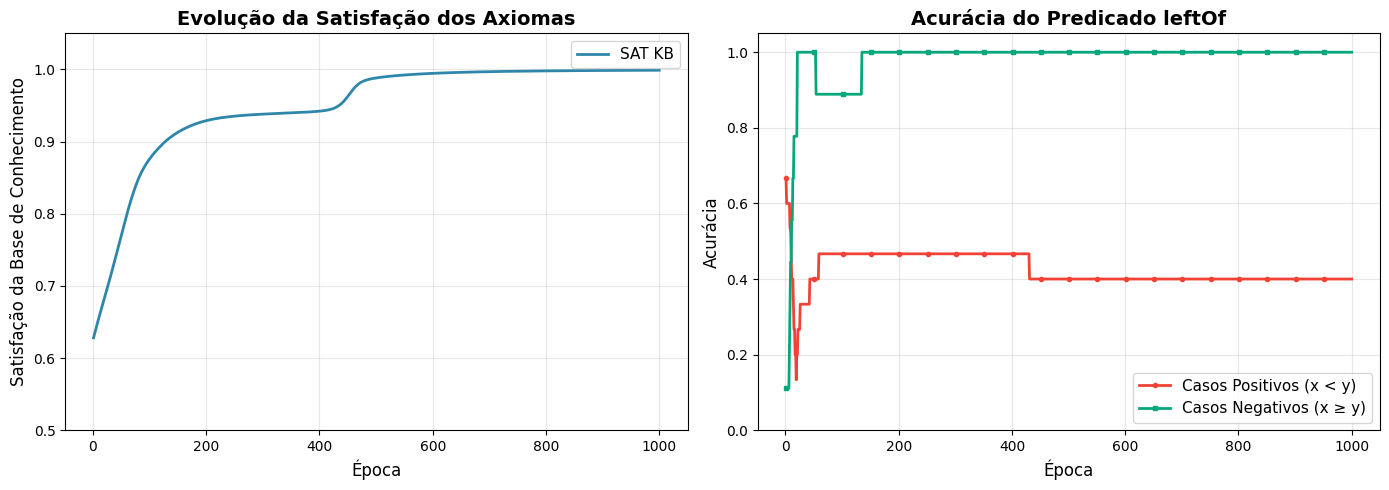

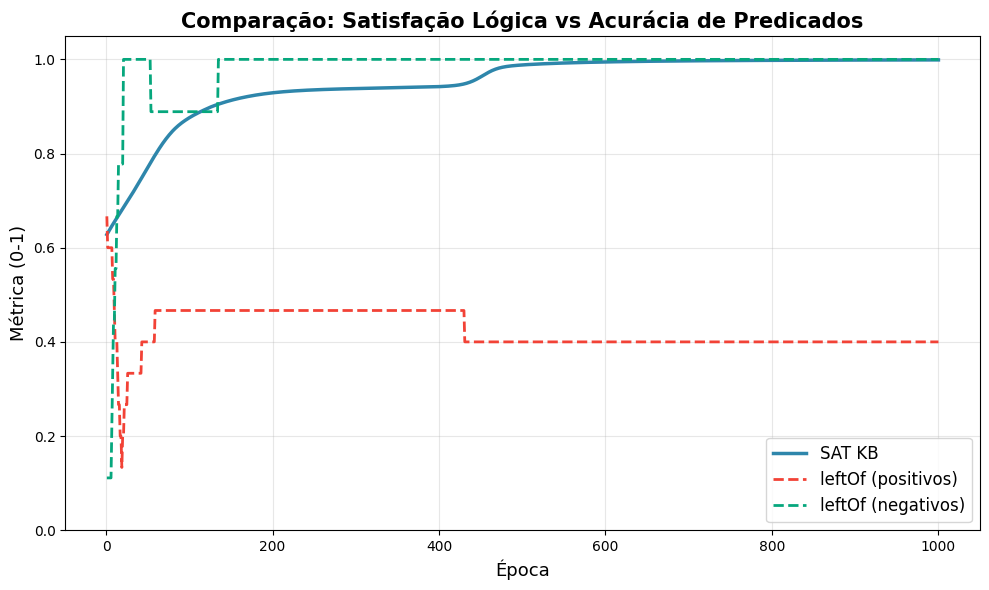

In [371]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregar dados
df = pd.read_csv("pre_learned_models/metrics.csv")

# Criar figura com melhor qualidade
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# GRÁFICO 1: SAT da KB
ax1.plot(df['Epoch'], df['train_sat_kb'], linewidth=2, label='SAT KB', color='#2E86AB')
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Satisfação da Base de Conhecimento', fontsize=12)
ax1.set_title('Evolução da Satisfação dos Axiomas', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim([0.5, 1.05])

# GRÁFICO 2: Acurácia leftOf por tipo de caso
ax2.plot(df['Epoch'], df['train_to_the_left_of_pos_case'], 
         linewidth=2, label='Casos Positivos (x < y)', color='#F24236', marker='o', markersize=3, markevery=50)
ax2.plot(df['Epoch'], df['train_to_the_left_of_neg_case'], 
         linewidth=2, label='Casos Negativos (x ≥ y)', color='#06A77D', marker='s', markersize=3, markevery=50)
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Acurácia', fontsize=12)
ax2.set_title('Acurácia do Predicado leftOf', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11, loc='lower right')
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('training_metrics_improved.png', dpi=300, bbox_inches='tight')
plt.show()

# GRÁFICO BÔNUS: Comparação direta
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['Epoch'], df['train_sat_kb'], linewidth=2.5, label='SAT KB', color='#2E86AB')
ax.plot(df['Epoch'], df['train_to_the_left_of_pos_case'], 
        linewidth=2, label='leftOf (positivos)', color='#F24236', linestyle='--')
ax.plot(df['Epoch'], df['train_to_the_left_of_neg_case'], 
        linewidth=2, label='leftOf (negativos)', color='#06A77D', linestyle='--')

ax.set_xlabel('Época', fontsize=13)
ax.set_ylabel('Métrica (0-1)', fontsize=13)
ax.set_title('Comparação: Satisfação Lógica vs Acurácia de Predicados', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='lower right')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [372]:
objects_to_query = generate_clevr_dataset()

x = ltn.Variable("x", objects_to_query)
y = ltn.Variable("y", objects_to_query)
z = ltn.Variable("z", objects_to_query)

In [373]:
# QUERY 1 FALTANTE
query_1 = Exists(
    x,
    And(
        isSmall(x),
        And(
            Exists(y, And(isCylinder(y), below(x, y))),
            Exists(z, And(isSquare(z), leftOf(x, z)))
        )
    )
)

print(f"Query 1 (pequeno abaixo de cilindro e esq. de quadrado): {query_1.value.item():.4f}")



query_2 = Exists(
    ltn.diag(x, y, z),
    And(
        isCone(x),
        And(
            isGreen(x),
            Or(
                And(leftOf(y, x), rightOf(z, x)),
                And(leftOf(z, x), rightOf(y, x))
            )
        )
    )
)

query_22 = Exists(
    ltn.diag(x, y, z),
    And(
        isCone(x),
        And(
            isGreen(x),
            inBetween(x, y, z)
        )
    )
)



print("Satisfação da Query (Existe um cone verde entre dois objetos):", query_2.value.item())
print("Satisfação da Query (Existe um cone verde entre dois objetos):", query_22.value.item())


# 1. PREDICADOS FALTANTES
x = ltn.Variable("x", objects_to_query)
y = ltn.Variable("y", objects_to_query)

q_left = Exists(x, Forall(y, leftOf(x, y)))
q_right = Exists(x, Forall(y, rightOf(x, y)))
print(f"Existe objeto mais à esquerda: {q_left.value.item():.4f}")
print(f"Existe objeto mais à direita: {q_right.value.item():.4f}")



Query 1 (pequeno abaixo de cilindro e esq. de quadrado): 0.0002
Satisfação da Query (Existe um cone verde entre dois objetos): 0.00011200669541722164
Satisfação da Query (Existe um cone verde entre dois objetos): 0.0010088860290125012
Existe objeto mais à esquerda: 0.1467
Existe objeto mais à direita: 0.9923


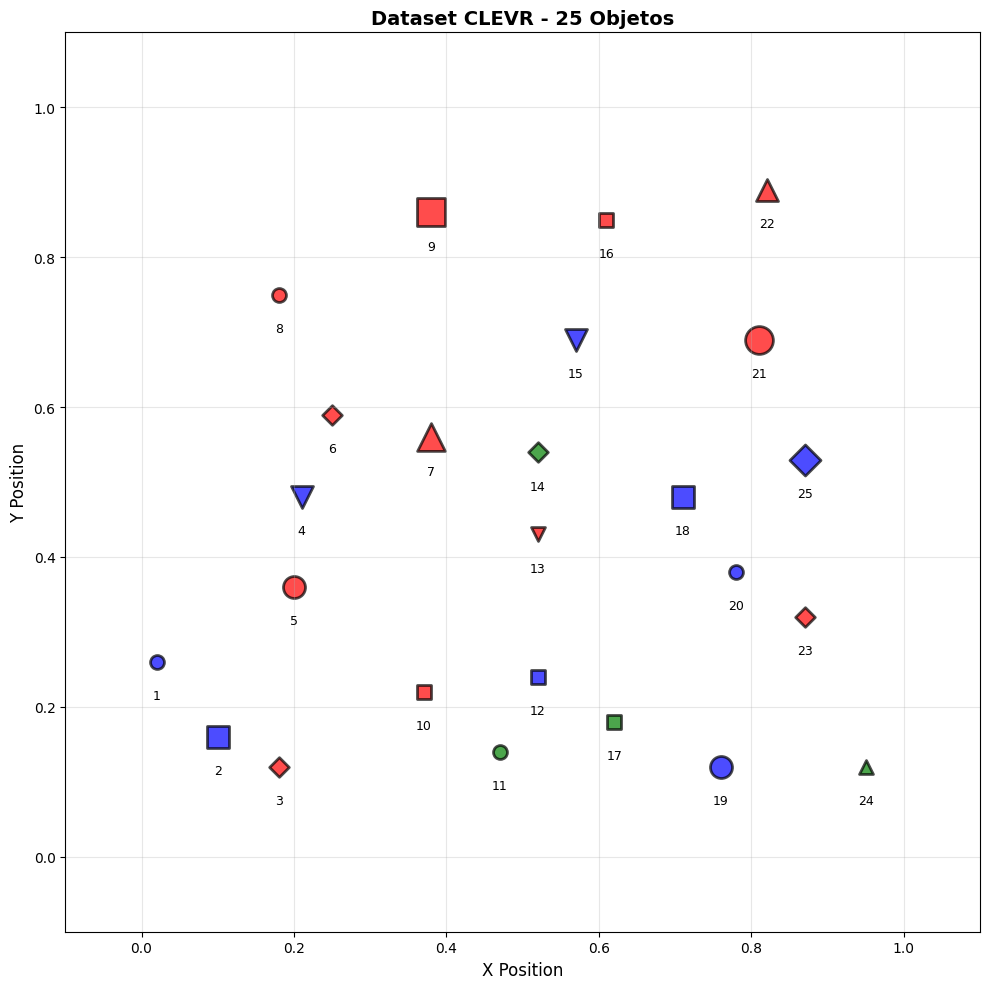

Violação da regra (Triângulos próximos com tamanhos diferentes): 0.00022565218387171626
Violação da regra (Triângulos próximos com tamanhos diferentes): 0.00017937707889359444


In [374]:
plot_clevr_scene(objects_to_query, "Dataset CLEVR - 25 Objetos")

query_3 = Exists(
    ltn.diag(x, y),
    And(
        And(
            isTriangle(x),
            And(
                isTriangle(y),
                closeTo(x, y)
            )
        ),
        Not(sameSize(x, y))
    )
)
query_33 = Exists(
    [x, y],
    And(
        And(
            isTriangle(x),
            And(
                isTriangle(y),
                closeTo(x, y)
            )
        ),
        Not(sameSize(x, y))
    )
)

print("Violação da regra (Triângulos próximos com tamanhos diferentes):", query_3.value.item())
print("Violação da regra (Triângulos próximos com tamanhos diferentes):", query_33.value.item())
